# Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Цель. Значение метрики RMSE на тестовой выборке должно быть не больше 48.

# Выполнение

In [10]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from lightgbm import LGBMRegressor

## Загрузка и ресемплирование данных по одному часу

In [4]:
try:
    data = pd.read_csv('taxi.csv', index_col=['datetime'], parse_dates=['datetime'], dayfirst=True)
except:
    data = pd.read_csv('/datasets/taxi.csv', index_col=['datetime'], parse_dates=['datetime'], dayfirst=True)

### resample

In [5]:
data_resampled = data.resample('H').mean()
st_check = data_resampled.num_orders

In [7]:
data_resampled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   num_orders  4416 non-null   float64
dtypes: float64(1)
memory usage: 69.0 KB


### Проверка на стационарность. Метод Дики-Фуллера

In [8]:
test = adfuller(st_check)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]>test[4]['5%']:
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

adf:  -3.0689242890279385
p-value:  0.028940051402614318
Critical values:  {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
Единичных корней нет, ряд стационарен


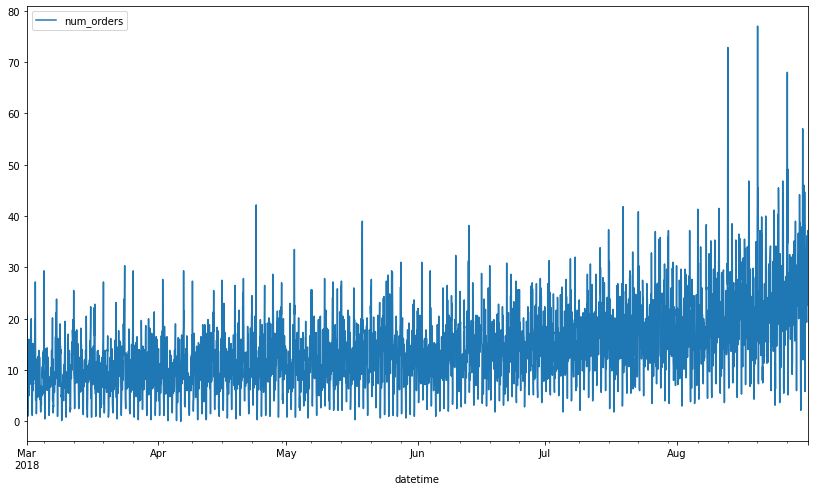

In [18]:
data_resampled.plot(figsize=(14, 8));

### Треды и сезонность

In [19]:
decomposed = seasonal_decompose(data_resampled)

#### Треды

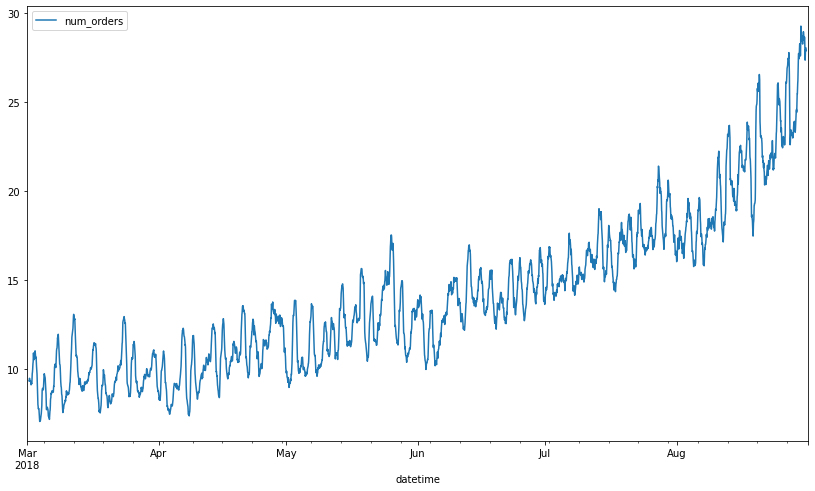

In [22]:
decomposed.trend.plot(figsize=(14, 8));

Из графика trend видно, что спрос на такси растет в течение рассматриваемого периода времени


#### Шумы

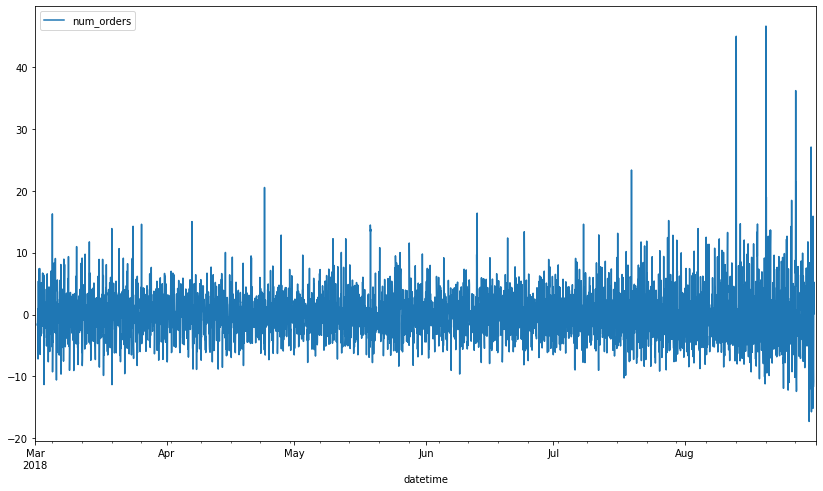

In [24]:
decomposed.resid.plot(figsize=(14, 8));

Из графика resid видно, что в августе были значения, похожие на выбросы.

#### Сезонность

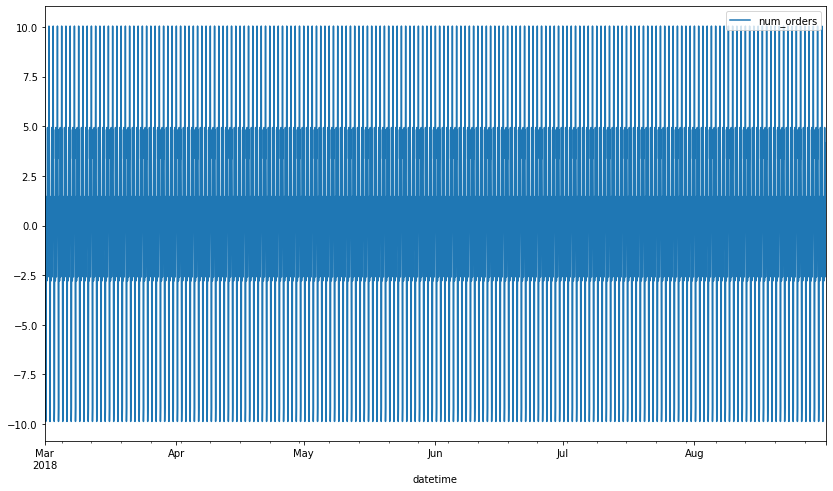

In [25]:
decomposed.seasonal.plot(figsize=(14, 8));

#### Сезонность в разрезе за август по дням

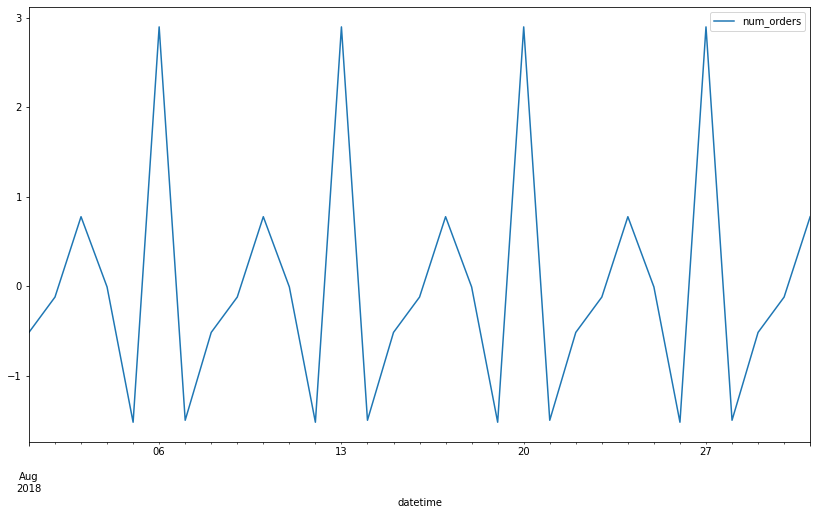

In [27]:
data_day = data.resample('1D').mean()
decomposed_day = seasonal_decompose(data_day['2018-08-01':'2018-09-01'])
decomposed_day.seasonal.plot(figsize=(14, 8));

Из графика seasonal видно, что закономерность наблюдается каждую неделю

#### Сезонность в разрезе по часу за три дня

In [28]:
data_hour = data.resample('1H').mean()

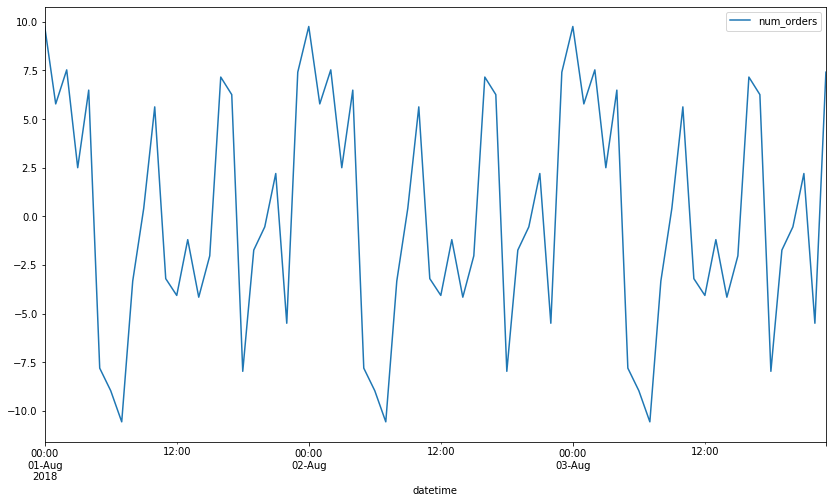

In [29]:
decomposed_hour = seasonal_decompose(data_hour['2018-08-01':'2018-08-03'])
decomposed_hour.seasonal.plot(figsize=(14, 8));

Из графика seasonal видно, что закономерность наблюдается каждые сутки

#### Сезонность в разрезе по неделям

data_week = data.resample('W').mean()

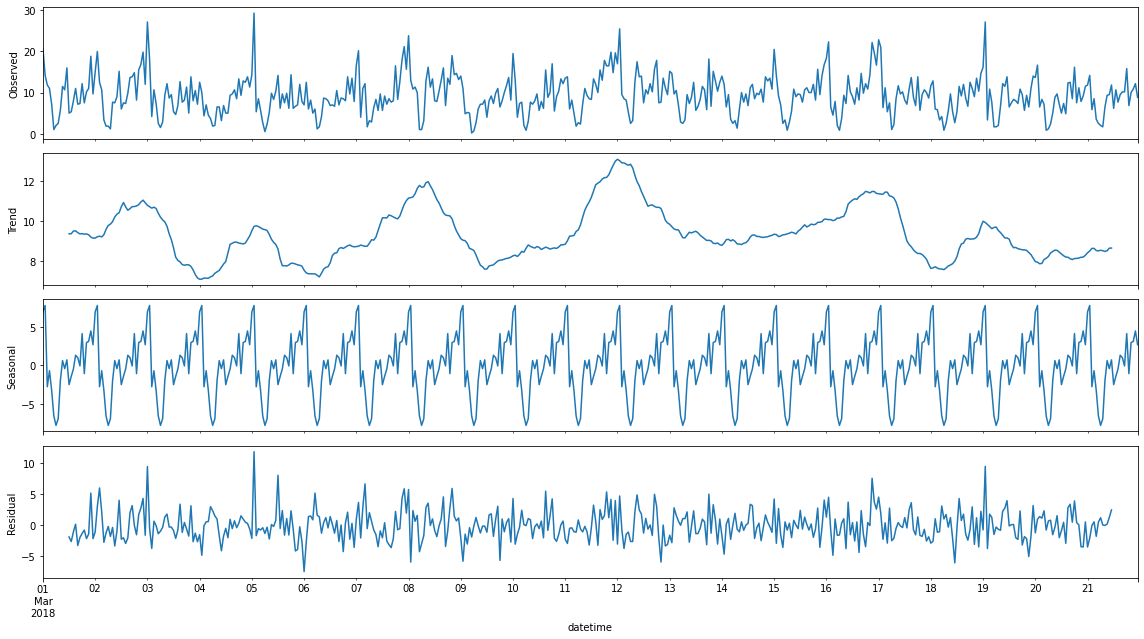

In [30]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
decomposed_week = seasonal_decompose(data_hour['2018-03-01':'2018-03-21'])
fig = decomposed_week.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

#### распределение количества заказов

array([[<AxesSubplot:title={'center':'num_orders'}>]], dtype=object)

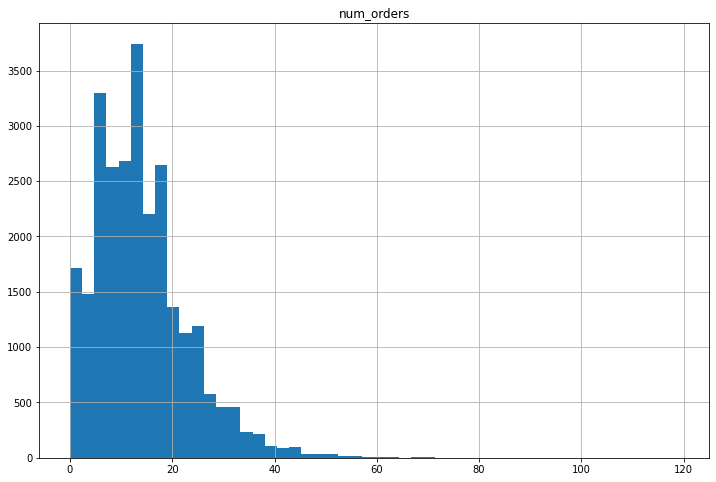

In [31]:
data.hist(bins=50, figsize=(12,8))

## Обучение моделей

In [33]:
RANDOM_STATE = 12345

In [34]:
def make_features(data, max_lag, rolling_mean_size):
    df = data.copy()
    df['month'] = df.index.month
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df

In [37]:
df = make_features(data_resampled, 15, 24)
data_train, data_valid = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE, shuffle=False)
data_valid, data_test = train_test_split(data_valid, test_size=0.5, random_state=RANDOM_STATE, shuffle=False)

In [38]:
data_train = data_train.dropna()
train_features = data_train.drop(['num_orders'], axis=1)
train_target = data_train['num_orders']
valid_features = data_valid.drop(['num_orders'], axis=1)
valid_target = data_valid['num_orders']
test_features = data_test.drop(['num_orders'], axis=1)
test_target = data_test['num_orders']

### LinearRegression

In [39]:
reg_model = LinearRegression()
reg_model.fit(train_features, train_target)
predictions_valid = reg_model.predict(valid_features)
predictions = reg_model.predict(test_features)
print(f'RMSE на валидационной выборке: {mean_squared_error(valid_target, predictions_valid)**0.5:0.2f}')
print(f'RMSE на тестовой выборке: {mean_squared_error(test_target, predictions)**0.5:0.2f}')

RMSE на валидационной выборке: 6.15
RMSE на тестовой выборке: 7.85


### RandomForest

In [40]:
rfr_model = RandomForestRegressor()
rfr_model.fit(train_features, train_target)
rfr_predictions_valid = rfr_model.predict(valid_features)
rfr_predictions = rfr_model.predict(test_features)
print(f'RMSE случайного леса на валидационной выборке: {mean_squared_error(valid_target, rfr_predictions_valid)**0.5:0.2f}')
print(f'RMSE случайного леса на тестовой выборке: {mean_squared_error(test_target, rfr_predictions)**0.5:0.2f}')

RMSE случайного леса на валидационной выборке: 4.67
RMSE случайного леса на тестовой выборке: 7.26


### LightGBM

In [42]:
lgb_model = LGBMRegressor()
lgb_model.fit(train_features, train_target)
lgb_predictions_valid = lgb_model.predict(valid_features)
lgb_predictions = lgb_model.predict(test_features)
print(f'RMSE на валидационной выборке: {mean_squared_error(valid_target, lgb_predictions_valid)**0.5:0.2f}')
print(f'RMSE на тестовой выборке: {mean_squared_error(test_target, lgb_predictions)**0.5:0.2f}')

RMSE на валидационной выборке: 4.64
RMSE на тестовой выборке: 8.05


## Вывод
Модель RandomForest показала лучший результат: 7.26